In [1]:
import pandas as pd 
import numpy as np 
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')



In [2]:
df_btc = pd.read_csv(r'../data/cryptoInd/btc_ind.csv')

In [3]:
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=df_btc['Date'], y=df_btc['close'], name='BITCOIN', mode='lines',line=dict(color='red')))
fig2.show()

In [4]:
inicial_date = '2021-01-01'
df_btc['Date'] = pd.to_datetime(df_btc['Date'])
inicial_date = pd.to_datetime(inicial_date)
df_btc = df_btc[df_btc['Date'] >= inicial_date]

# Correltion Matrix

## Scaling

In [5]:
df_btc.set_index('Date', inplace=True)
scaled_df = df_btc.copy()
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df_btc)
scaled_df = pd.DataFrame(scaled_feat, index = df_btc.index, columns=df_btc.columns)
scaled_df.head()

,adj_close,close,low,high,open,volume,SMA30,CMA30,EMA30,adx,...,bb_high,macd,macdsignal,macdhist,rsi,stdev,slowk,slowd,dollar_close,sp500_close
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,0.057325,0.057325,0.000000,0.064421,0.079851,0.188256,0.000000,0.000000,0.000000,0.983637,...,0.000000,0.797512,0.776167,0.755741,0.868900,0.389211,0.743343,0.864693,0.035275,0.000000
2021-01-05,0.110835,0.110835,0.039789,0.090818,0.057763,0.147290,0.020445,0.001932,0.021119,0.970967,...,0.030164,0.816153,0.793294,0.767926,0.912471,0.414189,0.757507,0.802520,0.000000,0.023916
2021-01-06,0.185835,0.185835,0.127227,0.155452,0.111707,0.170583,0.044274,0.004074,0.049470,0.971069,...,0.079306,0.849359,0.814561,0.817022,0.957059,0.481209,0.847211,0.794260,0.007524,0.043334
2021-01-07,0.253279,0.253279,0.206282,0.242810,0.186409,0.199083,0.073747,0.006402,0.083156,0.983328,...,0.137035,0.891352,0.841143,0.880037,0.986400,0.555831,0.971930,0.873712,0.030906,0.094114
2021-01-08,0.291060,0.291060,0.215508,0.289559,0.253897,0.209148,0.104922,0.008833,0.117605,1.000000,...,0.193085,0.930931,0.871427,0.923925,1.000000,0.621172,0.978436,0.950503,0.053317,0.113175


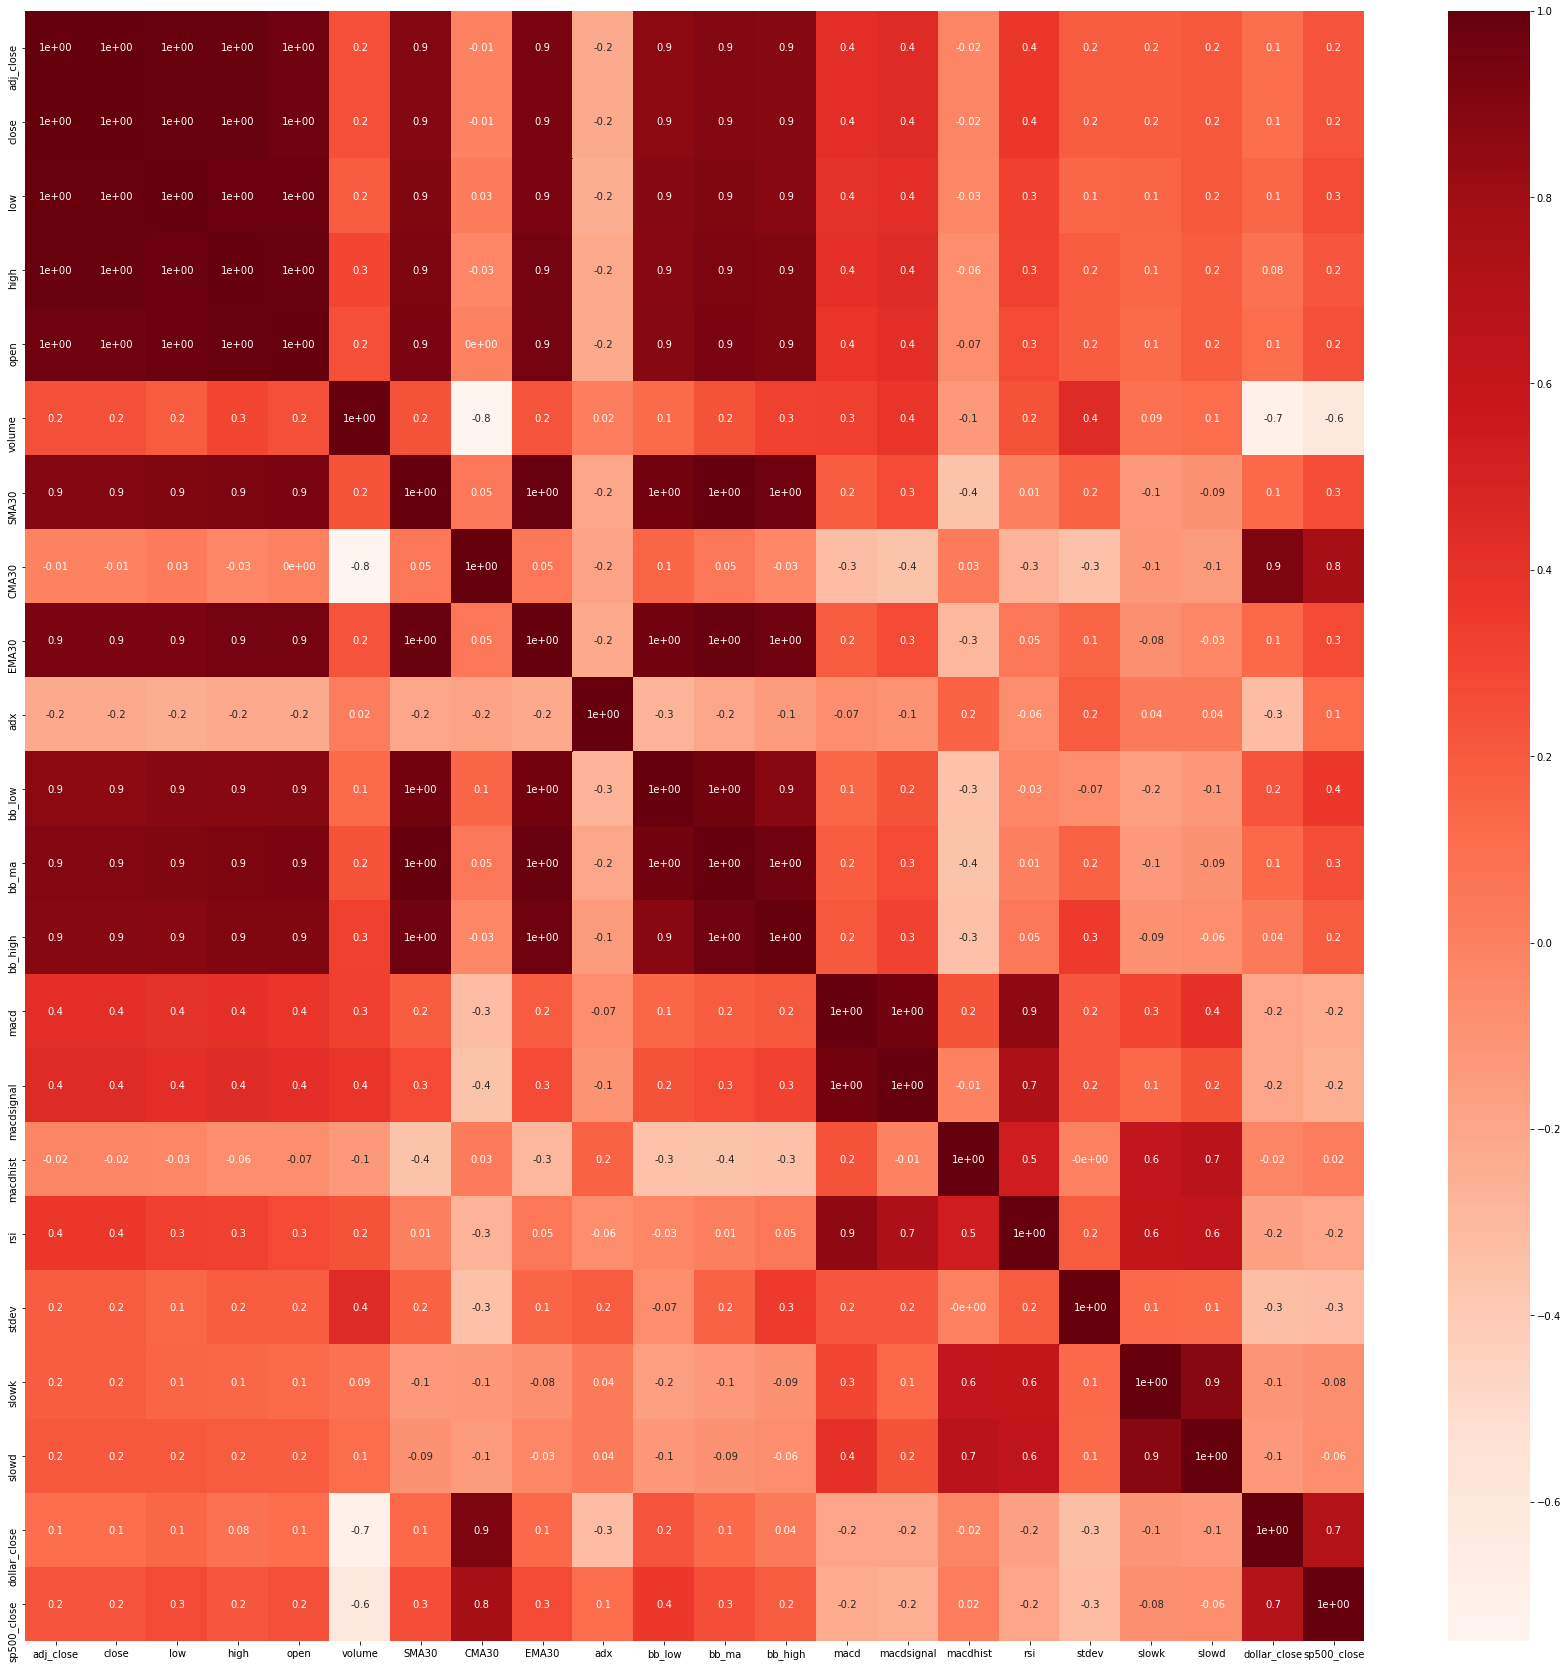

In [6]:
#Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(scaled_df.corr(method="spearman"), decimals=2)

def cor_heatmap(cor):
    plt.figure(figsize=(30,30))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()


cor_heatmap(corr)

In [7]:
scaled_df.columns

Index(['adj_close', 'close', 'low', 'high', 'open', 'volume', 'SMA30', 'CMA30',
       'EMA30', 'adx', 'bb_low', 'bb_ma', 'bb_high', 'macd', 'macdsignal',
       'macdhist', 'rsi', 'stdev', 'slowk', 'slowd', 'dollar_close',
       'sp500_close'],
      dtype='object')

In [8]:
scaled_df.drop(['low', 'high', 'open','SMA30','EMA30','bb_low',
 'bb_ma', 'bb_high', 'stdev', 'sp500_close'], axis=1, inplace=True)

## TimeSeries CV

In [9]:
y_cv = df_btc['close']
X_cv = scaled_df.drop(['close'], axis=1)

In [10]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(X_cv):
        X_train_cv, X_test_cv = X_cv[:len(train_index)], X_cv[len(train_index): (len(train_index)+len(test_index))]
        y_train_cv, y_test_cv = y_cv[:len(train_index)].values.ravel(), y_cv[len(train_index): (len(train_index)+len(test_index))].values.ravel()

## Hand-Made Sliding Window

In [11]:
df_btc.reset_index(inplace = True)
df_btc['Date'] = pd.to_datetime(df_btc['Date']).dt.date
y = df_btc.copy()
#y.reset_index(inplace=True)
X = scaled_df.drop(['close'], axis=1)
X.reset_index(inplace=True)
y['Date'] = pd.to_datetime(y['Date']).dt.date

In [12]:
def train_test_split_time_series(data, num_df, column_date):
    #data: data frame to split
    #num_df: number of differente splits
    #column_date: name of the column that has the Date info
    data[column_date] = pd.to_datetime(data[column_date]).dt.date
    date_split=[]
    max_date = data[column_date].max()
    min_date = data[column_date].min()
    range_date = max_date-min_date
    split_criteria = 0.2/(num_df-1)
    train = 0.6
    test = 0.8
    inicial = 0
    for i in range(num_df):
        list_to_add=[]
        list_to_add.append((min_date + range_date*inicial))
        list_to_add.append((min_date + range_date*train))
        list_to_add.append((min_date + range_date*test))
        train = train + split_criteria
        test = test + split_criteria
        inicial = inicial + split_criteria

        date_split.append(list_to_add)
    
    
    return date_split

In [13]:
date = train_test_split_time_series(X, num_df=3, column_date='Date')

In [14]:
train_1 = df_btc[(df_btc['Date'] >= date[0][0]) & (df_btc['Date'] < date[0][1])]
test_1 = df_btc[(df_btc['Date'] >= date[0][1]) & (df_btc['Date'] < date[0][2])]
y_train_1 = y[(y['Date'] >= date[0][0]) & (y['Date'] < date[0][1])]
y_test_1 = y[(y['Date'] >= date[0][1]) & (y['Date'] < date[0][2])]

train_2 = df_btc[(df_btc['Date'] >= date[1][0]) & (df_btc['Date'] < date[1][1])]
test_2 = df_btc[(df_btc['Date'] >= date[1][1]) & (df_btc['Date'] < date[1][2])]
y_train_2 = y[(y['Date'] >= date[1][0]) & (y['Date'] < date[1][1])]
y_test_2 = y[(y['Date'] >= date[1][1]) & (y['Date'] < date[1][2])]

train_3 = df_btc[(df_btc['Date'] >= date[2][0]) & (df_btc['Date'] < date[2][1])]
test_3 = df_btc[(df_btc['Date'] >= date[2][1]) & (df_btc['Date'] < date[2][2])]
y_train_3 = y[(y['Date'] >= date[2][0]) & (y['Date'] < date[2][1])]
y_test_3 = y[(y['Date'] >= date[2][1]) & (y['Date'] < date[2][2])]

In [15]:
def date_to_index(col_name, *args):
    for df in args:
        df.set_index(col_name, inplace = True)

In [16]:
date_to_index('Date', train_1, test_1, train_2, test_2, train_3, test_3)

In [17]:
date

[[datetime.date(2021, 1, 4),
  datetime.date(2021, 10, 16),
  datetime.date(2022, 1, 19)],
 [datetime.date(2021, 2, 20),
  datetime.date(2021, 12, 3),
  datetime.date(2022, 3, 8)],
 [datetime.date(2021, 4, 9),
  datetime.date(2022, 1, 19),
  datetime.date(2022, 4, 25)]]

In [18]:
y_train_1 = y_train_1['close']
y_test_1= y_test_1['close']

y_train_2 = y_train_2['close']
y_test_2= y_test_2['close']

y_train_3 = y_train_3['close']
y_test_3= y_test_3['close']

## TimeBaseCV

In [19]:
import pandas as pd
import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *

# code from: https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8"

class TimeBasedCV(object):
    '''
    Parameters 
    ----------
    train_period: int
        number of time units to include in each train set
        default is 30
    test_period: int
        number of time units to include in each test set
        default is 7
    freq: string
        frequency of input parameters. possible values are: days, months, years, weeks, hours, minutes, seconds
        possible values designed to be used by dateutil.relativedelta class
        deafault is days
    '''
    
    
    def __init__(self, train_period=30, test_period=7, freq='days'):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq

        
        
    def split(self, data, validation_split_date=None, date_column='record_date', gap=0):
        '''
        Generate indices to split data into training and test set
        
        Parameters 
        ----------
        data: pandas DataFrame
            your data, contain one column for the record date 
        validation_split_date: datetime.date()
            first date to perform the splitting on.
            if not provided will set to be the minimum date in the data after the first training set
        date_column: string, deafult='record_date'
            date of each record
        gap: int, default=0
            for cases the test set does not come right after the train set,
            *gap* days are left between train and test sets
        
        Returns 
        -------
        train_index ,test_index: 
            list of tuples (train index, test index) similar to sklearn model selection
        '''
        
        # check that date_column exist in the data:
        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []

        if validation_split_date==None:
            validation_split_date = data[date_column].min().date() + eval('relativedelta('+self.freq+'=self.train_period)')
        
        start_train = validation_split_date - eval('relativedelta('+self.freq+'=self.train_period)')
        end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
        start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
        end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        while end_test < data[date_column].max().date():
            # train indices:
            cur_train_indices = list(data[(data[date_column].dt.date>=start_train) & 
                                     (data[date_column].dt.date<end_train)].index)

            # test indices:
            cur_test_indices = list(data[(data[date_column].dt.date>=start_test) &
                                    (data[date_column].dt.date<end_test)].index)
            
            #print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
            #      "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)

            # update dates:
            start_train = start_train + eval('relativedelta('+self.freq+'=self.test_period)')
            end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
            start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
            end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        # mimic sklearn output  
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        
        return index_output
    
    
    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits

In [20]:
y_tbcv = df_btc['close']
X_tbcv = scaled_df.drop(['close'], axis=1)

In [21]:
X_tbcv.reset_index(inplace=True)
X_tbcv['Date'] = pd.to_datetime(X_tbcv['Date'], format='%Y-%m-%d')

In [22]:
tscv = TimeBasedCV(train_period=100,
                   test_period=12,
                   freq='days')

for train_index, test_index in tscv.split(X_tbcv,date_column='Date'):
    data_train   = X_tbcv.loc[train_index]
    data_train.set_index('Date', inplace=True)
    target_train = y_tbcv.loc[train_index]
    data_test    = X_tbcv.loc[test_index]
    target_test  = y_tbcv.loc[test_index]
    data_test.set_index('Date', inplace=True)

    print("TRAIN: From"+ str(data_train.index.min())+" to "+str(data_train.index.max()))
    print("TEST: From"+ str(data_test.index.min())+" to "+str(data_test.index.max()))

# get number of splits
tscv.get_n_splits()

TRAIN: From2021-01-04 00:00:00 to 2021-04-13 00:00:00
TEST: From2021-04-14 00:00:00 to 2021-04-23 00:00:00
TRAIN: From2021-01-19 00:00:00 to 2021-04-23 00:00:00
TEST: From2021-04-26 00:00:00 to 2021-05-07 00:00:00
TRAIN: From2021-01-28 00:00:00 to 2021-05-07 00:00:00
TEST: From2021-05-10 00:00:00 to 2021-05-19 00:00:00
TRAIN: From2021-02-09 00:00:00 to 2021-05-19 00:00:00
TEST: From2021-05-20 00:00:00 to 2021-05-28 00:00:00
TRAIN: From2021-02-22 00:00:00 to 2021-05-28 00:00:00
TEST: From2021-06-01 00:00:00 to 2021-06-11 00:00:00
TRAIN: From2021-03-05 00:00:00 to 2021-06-11 00:00:00
TEST: From2021-06-14 00:00:00 to 2021-06-24 00:00:00
TRAIN: From2021-03-17 00:00:00 to 2021-06-24 00:00:00
TEST: From2021-06-25 00:00:00 to 2021-07-06 00:00:00
TRAIN: From2021-03-29 00:00:00 to 2021-07-06 00:00:00
TEST: From2021-07-07 00:00:00 to 2021-07-16 00:00:00
TRAIN: From2021-04-12 00:00:00 to 2021-07-16 00:00:00
TEST: From2021-07-19 00:00:00 to 2021-07-30 00:00:00
TRAIN: From2021-04-22 00:00:00 to 202

31

# Models

## Function to Apply the Models

In [23]:
def show_results(df,X_train, X_test, y_train, y_test, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    preds = [y_test]
    count = 0
    # for each model passed as argument
    for arg in args:
        print(arg)
        # applies the model
        model_fit = arg.fit(X_train, y_train)
        # predicts training
        y_pred_test = model_fit.predict(X_test)
        # evaluate predictions
        mae = mean_absolute_error(y_test, y_pred_test)
        mse = mean_squared_error(y_test, y_pred_test)
        r2 = r2_score(y_test, y_pred_test)
        preds.append(y_pred_test)
        # store the results in the right row
        df.iloc[count] = mae, mse, r2
        count+=1
    
    fig = px.line(X_test, x = X_test.index, y = preds)
    fig.show()
    return df

In [24]:
def avg_score(model, X, y, splits,split_method = 'tscv', train_period_split = 30,test_period_split=7):

    # create lists to store the results from the different models 
    mae_list = []
    mse_list = []
    r2_list = []
    flag = 0 # feat sel flag to not keep printing 

    if split_method == 'hmcv':
        X_tbcv = X.reset_index()
        X_tbcv['Date'] = pd.to_datetime(X_tbcv['Date'], format='%Y-%m-%d')                
        tscv = TimeBasedCV(train_period=train_period_split,
                        test_period=test_period_split,
                        freq='days')

        fig = make_subplots(rows=1, cols=1)
        fig2 = go.Figure()

        for train_index, test_index in tscv.split(X_tbcv,date_column='Date'):
                X_train   = X_tbcv.loc[train_index]
                y_train = y.loc[train_index]
                X_val    = X_tbcv.loc[test_index]
                y_val  = y.loc[test_index]
                X_train.set_index('Date', inplace=True)                
                X_val.set_index('Date', inplace=True)

                # applies the model 
                model_fit = model.fit(X_train, y_train)
                #predicts validation 
                y_pred_val = model_fit.predict(X_val)
                
                # prints metric results         
                #metrics(X_train, X_val, y_train, y_pred_train, y_val, y_pred_val, model)
                value_mae = mean_absolute_error(y_val, y_pred_val)
                value_mse = mean_squared_error(y_val, y_pred_val)
                value_r2 = r2_score(y_val, y_pred_val)
                # append the accuracies, the time and the number of iterations in the corresponding list
                mae_list.append(value_mae)
                mse_list.append(value_mse)
                r2_list.append(value_r2)

                #print(len(X_val), len(y_val), len(y_pred_val))
                real_name = 'real '+ str(X_val.index.min().day)+"-"+ str(X_val.index.min().month)+"-"+ str(X_val.index.min().year)+" to "\
                                   + str(X_val.index.max().day)+"-"+ str(X_val.index.max().month)+"-"+ str(X_val.index.max().year)
                pred_name = 'pred '+ str(X_val.index.min().day)+"-"+ str(X_val.index.min().month)+"-"+ str(X_val.index.min().year)+" to"\
                                   + str(X_val.index.max().day)+"-"+ str(X_val.index.max().month)+"-"+ str(X_val.index.max().year)+" "


                fig2.add_trace(go.Scatter(x=X_val.index, y=y_val, name=real_name, mode='lines',line=dict(color='green')))
                fig2.add_trace(go.Scatter(x=X_val.index, y=y_pred_val, name=pred_name, mode='lines', line=dict(color='red')))
                
                
        model_name = str(model)+"Number of Splits: "+ str(tscv.get_n_splits())
        
        fig2.update_layout(dict(updatemenus=[
                                dict(
                                type = "buttons",
                                direction = "left",
                                buttons=list([
                                        dict(
                                        args=["visible", "legendonly"],
                                        label="Deselect All",
                                        method="restyle"
                                        ),
                                        dict(
                                        args=["visible", True],
                                        label="Select All",
                                        method="restyle"
                                        )
                                ]),
                                pad={"r": 10, "t": 10},
                                showactive=False,
                                x=1,
                                xanchor="right",
                                y=1.1,
                                yanchor="top"
                                ),
                        ]
                ))

        fig2.update_layout(height=1000, width=1000,
                title_text=model_name)
        fig2.show()     


        
    elif split_method == 'tscv':
        fig = make_subplots(rows=splits, cols=1)
        #Splitting to Training set and Test set
        timesplit= TimeSeriesSplit(n_splits=splits)
        flag = 1
        for train_index, test_index in timesplit.split(X):
                X_train, X_val = X[:len(train_index)], X[len(train_index): (len(train_index)+len(test_index))]
                y_train, y_val = y[:len(train_index)].values.ravel(), y[len(train_index): (len(train_index)+len(test_index))].values.ravel()
                # applies the model 
                model_fit = model.fit(X_train, y_train)
                #predicts validation 
                y_pred_val = model_fit.predict(X_val)
                
                # prints metric results         
                #metrics(X_train, X_val, y_train, y_pred_train, y_val, y_pred_val, model)
                value_mae = mean_absolute_error(y_val, y_pred_val)
                value_mse = mean_squared_error(y_val, y_pred_val)
                value_r2 = r2_score(y_val, y_pred_val)
                # append the accuracies, the time and the number of iterations in the corresponding list
                mae_list.append(value_mae)
                mse_list.append(value_mse)
                r2_list.append(value_r2)

                
                title_y = "Value from "+str(X_val.index.min())+" to "+str(X_val.index.max())
                 
                fig.add_trace(go.Scatter(x=X_val.index, y=y_val, name='real', mode='lines', line=dict(color="#0000ff")),
                row=flag,col=1)
                fig.add_trace(go.Scatter(x=X_val.index, y=y_pred_val, name='prediction', mode='lines', line=dict(color="#0000ff")),
                row=flag,col=1)
                fig.update_xaxes(title_text= title_y, row=flag, col=1, title_font_size=10)
                
                flag+=1
                
        model_name = str(rf_se)

        fig.update_layout(height=1000, width=1000,
                title_text=model_name)
        fig.show()

        
        
  
    avg_mae = round(np.mean(mae_list),3)
    std_mae = round(np.std(mae_list),2)
    avg_mse = round(np.mean(mse_list),3)
    std_mse = round(np.std(mse_list),2)
    avg_r2 = round(np.mean(r2_list),3)
    std_r2 = round(np.std(r2_list),2)

    return str(avg_mae) + '+/-' + str(std_mae),\
            str(avg_mse) + '+/-' + str(std_mse) , str(avg_r2) + '+/-' + str(std_r2)

## Random Forest

In [51]:
rf_se = RandomForestRegressor(random_state=10,criterion='mse')
rf_ae = RandomForestRegressor(random_state=10,criterion='mae')
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['mse','mae'])
show_results(df, X_train_cv, X_test_cv, y_train_cv, y_test_cv, rf_ae, rf_se)


RandomForestRegressor(criterion='mae', random_state=10)
RandomForestRegressor(random_state=10)


,MAE,MSE,R2
mse,81.084272,9608.793905,0.9985
mae,84.46932,12916.070334,0.997984


In [52]:
rf_5 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=5)
rf_20 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20)
rf_50 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=50)
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['5','20', '50'])
show_results(df, X_train_cv, X_test_cv, y_train_cv, y_test_cv,rf_5, rf_20,rf_50)

RandomForestRegressor(criterion='mae', max_depth=5, random_state=10)
RandomForestRegressor(criterion='mae', max_depth=20, random_state=10)
RandomForestRegressor(criterion='mae', max_depth=50, random_state=10)


,MAE,MSE,R2
5,99.528432,14630.615236,0.997717
20,81.084272,9608.793905,0.9985
50,81.084272,9608.793905,0.9985


In [54]:
rf_auto = RandomForestRegressor(random_state=10,criterion='mae', max_depth=5, max_features='auto')
rf_sqrt = RandomForestRegressor(random_state=10,criterion='mae', max_depth=5, max_features='sqrt')
rf_log2 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=5,max_features='log2' )
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['auto','sqrt', 'log2'])
show_results(df, X_train_cv, X_test_cv, y_train_cv, y_test_cv,rf_auto, rf_sqrt,rf_log2)

RandomForestRegressor(criterion='mae', max_depth=5, random_state=10)
RandomForestRegressor(criterion='mae', max_depth=5, max_features='sqrt',
                      random_state=10)
RandomForestRegressor(criterion='mae', max_depth=5, max_features='log2',
                      random_state=10)


,MAE,MSE,R2
auto,99.528432,14630.615236,0.997717
sqrt,895.752054,1534344.093534,0.760528
log2,895.752054,1534344.093534,0.760528


In [57]:
rf_10 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=5, max_features='sqrt', n_estimators=10)
rf_20 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=5, max_features='sqrt',n_estimators=20)
rf_30 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=5,max_features='sqrt', n_estimators=30)
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['10','20', '30'])
show_results(df, X_train_cv, X_test_cv, y_train_cv, y_test_cv,rf_10, rf_20,rf_30)

RandomForestRegressor(criterion='mae', max_depth=5, max_features='sqrt',
                      n_estimators=10, random_state=10)
RandomForestRegressor(criterion='mae', max_depth=5, max_features='sqrt',
                      n_estimators=20, random_state=10)
RandomForestRegressor(criterion='mae', max_depth=5, max_features='sqrt',
                      n_estimators=30, random_state=10)


,MAE,MSE,R2
10,790.89028,1136690.951614,0.822591
20,705.789772,767480.774027,0.880216
30,796.48339,1103635.2167,0.827751


In [60]:
rf_final = RandomForestRegressor(random_state=10,criterion='mae', max_depth=5, max_features='sqrt', n_estimators=20)
y = df_btc['close']
X = scaled_df.drop(['close'], axis=1)
avg_score(rf_final, X, y, 5, 'hmcv', train_period_split=100, test_period_split=5)

('2872.394+/-2010.16', '14073510.321+/-16756825.38', '-24.467+/-55.1')

## Gradient Boost

In [40]:
gb_mae = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 130)
gb_mse = GradientBoostingRegressor(random_state = 10 , criterion='mse', n_estimators = 130)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['mae','mse'])
show_results(df, train_3, test_3, y_train_3, y_test_3,gb_mae, gb_mse)

GradientBoostingRegressor(criterion='mae', n_estimators=130, random_state=10)
GradientBoostingRegressor(criterion='mse', n_estimators=130, random_state=10)


,MAE,MSE,R2
mae,72.891276,8603.014035,0.998964
mse,82.877791,10837.960193,0.998695


In [44]:
gb_50 = GradientBoostingRegressor(random_state = 10 , criterion='mse', n_estimators = 50)
gb_100 = GradientBoostingRegressor(random_state = 10 , criterion='mse', n_estimators = 100)
gb_150 = GradientBoostingRegressor(random_state = 10 , criterion='mse', n_estimators = 150)
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['50','100', '150'])
show_results(df, train_3, test_3, y_train_3, y_test_3,gb_50, gb_100, gb_150)

GradientBoostingRegressor(criterion='mse', n_estimators=50, random_state=10)
GradientBoostingRegressor(criterion='mse', random_state=10)
GradientBoostingRegressor(criterion='mse', n_estimators=150, random_state=10)


,MAE,MSE,R2
50,85.840398,11456.490304,0.99862
100,81.90792,10889.977152,0.998689
150,83.080488,10774.353237,0.998703


In [48]:
gb_auto = GradientBoostingRegressor(random_state = 10 , criterion='mse', n_estimators = 50, max_features=  'auto' )
gb_sqrt = GradientBoostingRegressor(random_state = 10 , criterion='mse', n_estimators = 50, max_features = 'sqrt')
gb_log2 = GradientBoostingRegressor(random_state = 10 , criterion='mse', n_estimators = 50, max_features=  'log2')
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['auto','sqrt', 'log2'])
show_results(df, train_3, test_3, y_train_3, y_test_3,gb_auto, gb_sqrt, gb_log2)

GradientBoostingRegressor(criterion='mse', max_features='auto', n_estimators=50,
                          random_state=10)
GradientBoostingRegressor(criterion='mse', max_features='sqrt', n_estimators=50,
                          random_state=10)
GradientBoostingRegressor(criterion='mse', max_features='log2', n_estimators=50,
                          random_state=10)


,MAE,MSE,R2
auto,85.840398,11456.490304,0.99862
sqrt,842.218551,1104628.231286,0.866988
log2,842.218551,1104628.231286,0.866988


In [49]:
gb_final = GradientBoostingRegressor(random_state = 10 , criterion='mse', n_estimators = 50, max_features=  'log2')
y = df_btc['close']
X = scaled_df.drop(['close'], axis=1)
avg_score(gb_final, X, y,5, 'hmcv', train_period_split=100, test_period_split=5)

('2429.325+/-1833.38', '10618765.781+/-12949817.52', '-32.202+/-171.18')

# Neural Nerworks

In [34]:
nn_2525 = MLPRegressor(hidden_layer_sizes=(25,25), random_state=15,max_iter = 3000)
nn_10101010 = MLPRegressor(hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)
nn_10 = MLPRegressor(hidden_layer_sizes=(10), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['2525','101010', '10'])
show_results(df, X_train_cv, X_test_cv, y_train_cv, y_test_cv,nn_2525, nn_10101010, nn_10)

MLPRegressor(hidden_layer_sizes=(25, 25), max_iter=3000, random_state=15)
MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10), max_iter=3000,
             random_state=15)
MLPRegressor(hidden_layer_sizes=10, max_iter=3000, random_state=15)


,MAE,MSE,R2
2525,8667.821548,83990496.017365,-12.108783
101010,710.020178,646118.583308,0.899157
10,41348.367264,1715409235.17648,-266.731806


In [35]:
nn_identity = MLPRegressor(activation = 'identity',hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)
nn_logistic = MLPRegressor(activation = 'logistic',hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)
nn_tanh = MLPRegressor(activation = 'tanh',hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)
nn_relu = MLPRegressor(activation = 'relu',hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['identity','logistic', 'tanh', 'relu'])
show_results(df, X_train_cv, X_test_cv, y_train_cv, y_test_cv,nn_identity, nn_logistic, nn_tanh, nn_relu)

MLPRegressor(activation='identity', hidden_layer_sizes=(10, 10, 10, 10),
             max_iter=3000, random_state=15)
MLPRegressor(activation='logistic', hidden_layer_sizes=(10, 10, 10, 10),
             max_iter=3000, random_state=15)
MLPRegressor(activation='tanh', hidden_layer_sizes=(10, 10, 10, 10),
             max_iter=3000, random_state=15)
MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10), max_iter=3000,
             random_state=15)


,MAE,MSE,R2
identity,238.766536,93499.070478,0.985407
logistic,42511.003696,1813592627.752527,-282.05574
tanh,42509.127239,1813433091.174119,-282.03084
relu,710.020178,646118.583308,0.899157


In [36]:
nn_lbfgs = MLPRegressor(solver = 'lbfgs', activation = 'relu',hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)
nn_sgd = MLPRegressor(solver = 'sgd', activation = 'relu',hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)
nn_adam = MLPRegressor(solver = 'adam', activation = 'relu',hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['lbfgs','sgd', 'adam'])
show_results(df, X_train_cv, X_test_cv, y_train_cv, y_test_cv,nn_lbfgs, nn_sgd, nn_adam)

MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10), max_iter=3000,
             random_state=15, solver='lbfgs')
MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10), max_iter=3000,
             random_state=15, solver='sgd')
MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10), max_iter=3000,
             random_state=15)


,MAE,MSE,R2
lbfgs,0.000245,0.0,1.0
sgd,2719486331008166601006530012802947444057199836...,inf,-inf
adam,710.020178,646118.583308,0.899157


In [37]:
nn_constant = MLPRegressor(learning_rate = 'constant',solver = 'adam', activation = 'relu',
hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)
nn_invscaling = MLPRegressor(learning_rate = 'invscaling',solver = 'adam', activation = 'relu',
hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)
nn_adaptive = MLPRegressor(learning_rate = 'adaptive',solver = 'adam', activation = 'relu',
hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['constant','invscaling', 'nn_adaptive'])
show_results(df, X_train_cv, X_test_cv, y_train_cv, y_test_cv,nn_constant, nn_invscaling, nn_adam)

MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10), max_iter=3000,
             random_state=15)
MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10), learning_rate='invscaling',
             max_iter=3000, random_state=15)
MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10), max_iter=3000,
             random_state=15)


,MAE,MSE,R2
constant,710.020178,646118.583308,0.899157
invscaling,710.020178,646118.583308,0.899157
nn_adaptive,710.020178,646118.583308,0.899157


In [38]:
nn_final = MLPRegressor(random_state=15, max_iter= 3000, hidden_layer_sizes=(10,10,10,10), activation='relu', solver = 'adam')
y = df_btc['close']
X = scaled_df.drop(['close'], axis=1)
avg_score(nn_final, X, y,5, 'hmcv', train_period_split=100, test_period_split=5)

('5765.198+/-3407.85', '46474648.368+/-46858353.32', '-96.295+/-229.75')